# Title

In [1]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from GenomicWindows import window
import GenomicIntervals

numpy.random.seed(7)

Parallel computing:

In [2]:
# import ipyparallel
# from ipyparallel import depend, require

# # create client & view
# rc = ipyparallel.Client()
# dview = rc[:]
# bview = rc.load_balanced_view() # you can set block=True to have this apply globally

# # scatter 'id', so id=0,1,2 on engines 0,1,2
# dview.scatter('node_id', rc.ids, flatten=True)
# print("Engine IDs: ", dview['node_id'])
# # create a Reference to `id`. This will be a different value on each engine
# ref = ipyparallel.Reference('node_id')

# with dview.sync_imports(): # imports libs across dview
#     import re, os, sys, pickle
#     from pathlib import Path
#     import numpy
#     import pandas
#     from pandas import DataFrame
    
# dview.execute('numpy.random.seed(7)')

# def scatter_func(f):
#     dview.scatter(f.__name__, [f]*len(bview), flatten=True)    

# def getmem():
#     p = subprocess.Popen("echo $HOSTNAME", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     stdout, stderr = p.communicate()
#     return node_id, stdout.decode().strip(), resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024

# def print_mem():
#     for node_id, host_name, mem in  dview.apply(getmem).get():
#         print("{}{: >10}{: 10.2f} Mb". format(node_id, host_name, mem))

# def parallel_apply(grouped_df, fun):
#     return pandas.concat(dview.map_sync(fun, (group for name, group in grouped_df)))

Plotting setup:

In [3]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle, Polygon
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

# import random
# df = DataFrame({'x': random.sample(range(1, 100), 5), 
#                 'y': random.sample(range(1, 100), 5),
#                 'z': [1,0,0,1,0],
#                 'k': ['male','male','male','female','female'] })

# with sns.color_palette("Set1"):
#     with sns.axes_style('dark'): # whitegrid, ticks
#         with sns.plotting_context('paper', font_scale=1): # paper, notebook, talk”, poster
#             g = sns.lmplot('x', 'y', data=df, hue='z', col='k', fit_reg=False, size=3)

# # mpld3.display(ax.fig) # if you want d3

Ignore deprecation warnings from mainly seaborn:

In [4]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

### Analysis dirs

In [5]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Import variables global to the entire analysis:

In [6]:
import analysis_globals

## Local code in the scripts dir on the cluster:

In [7]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Convenience functions

In [8]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

## Load meta data

In [9]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')
# region_colors = dict(zip(list(region_categories), 
#                          ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', 
#                           '#ff7f00', '#ffff33', '#a65628']))

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

chr_names = [str(x) for x in list(range(1, 23)) + ["Y", "X"]]
chr_lens = [chromosome_lengths[str(x)] for x in chr_names]
figwidth = max(chr_lens)

## Load low-ILS regions

In [11]:
great_ape_ils_analysis_dir = Path('/home/kmt/projects/great_ape_ils_maps/analyses')

window_size = 100000
col_names = ["start", "end", 'top1', 'top2', 'top3', 'top4']

def call_low_ils_regions(df, max_ils, min_analyzed):
    df = (df
          .assign(prop_ils = lambda df: df.prop_ils.where(df.fraction_analyzed >= min_analyzed)) 
          .loc[:, ['chrom', 'start', 'end', 'prop_ils']]
          .assign(run = 1, 
                  islow = lambda df: df.prop_ils <= max_ils) # turn masked into nan to break runs at missing data
          .assign(test = lambda df: (df.islow != df.islow.shift()).cumsum())
          .groupby(['chrom', 'test'])
                  .aggregate({'start': 'min', 'end': 'max', 'run': 'sum', 'prop_ils': 'mean'})
                  .reset_index()
          .loc[lambda df: df.prop_ils <= max_ils, :]
         )
    return df

max_ils_in_low_regions = 0.05
minimal_fraction_analyzed_ils = 0.3

lst = list()
for chrom in chromosome_lengths:
    if chrom == 'Y':
        continue
    path = great_ape_ils_analysis_dir / "multiz_hg19_panTro3_gorGor3_ponAbe2/results/chr1-22_X.statesBin1000000chr{}.import.coalhmm.list_chrHASH4563609074768454572.hdfmerge.minmaf500_maxgap100_maxn02_junkNn.tbl".format(chrom)

    
    df = (pandas.read_table(path, names=col_names)
                            .assign(chrom = chrom,
                                    prop_ils = lambda df: (df.top3 + df.top4) / (df.top1 + df.top2 + df.top3 + df.top4),
                                    fraction_analyzed = lambda df: (df.top1 + df.top2 + df.top3 + df.top4) / window_size)
                           )
    df = call_low_ils_regions(df, 
                              max_ils_in_low_regions, 
                              minimal_fraction_analyzed_ils)
    lst.append(df)

human_chimp_ils = pandas.concat(lst)

lst = list()
for chrom in chromosome_lengths:
    if chrom == 'Y':
        continue
    path = great_ape_ils_analysis_dir / "multiz_hg19_ponAbe2_nomLeu1_rheMac2/results/chr1-22_X.statesBin1000000chr{}.import.coalhmm.list_chrHASH-5473120441099014340.hdfmerge.minmaf500_maxgap100_maxn02_junkNn.tbl".format(chrom)

    
    df = (pandas.read_table(path, names=col_names)
                            .assign(chrom = chrom,
                                    prop_ils = lambda df: (df.top3 + df.top4) / (df.top1 + df.top2 + df.top3 + df.top4),
                                    fraction_analyzed = lambda df: (df.top1 + df.top2 + df.top3 + df.top4) / window_size)
                           )
    df = call_low_ils_regions(df, 
                              max_ils_in_low_regions, 
                              minimal_fraction_analyzed_ils)
    lst.append(df)

human_orang_ils = pandas.concat(lst)

## Circ RNA data

In [12]:
df = pandas.read_table(data_dir / 'cytoBankhg19.txt', 
                       header=None, names=['chrom', 'start', 'end', 'name', 'type'])

df = df.loc[df.type == 'acen'].groupby(['chrom']).agg({'start': 'min', 'end': 'max'}).reset_index()
centromeres = dict()
for tup in df.itertuples():
    centromeres[tup.chrom.replace('chr', '')] = (tup.start, tup.end)

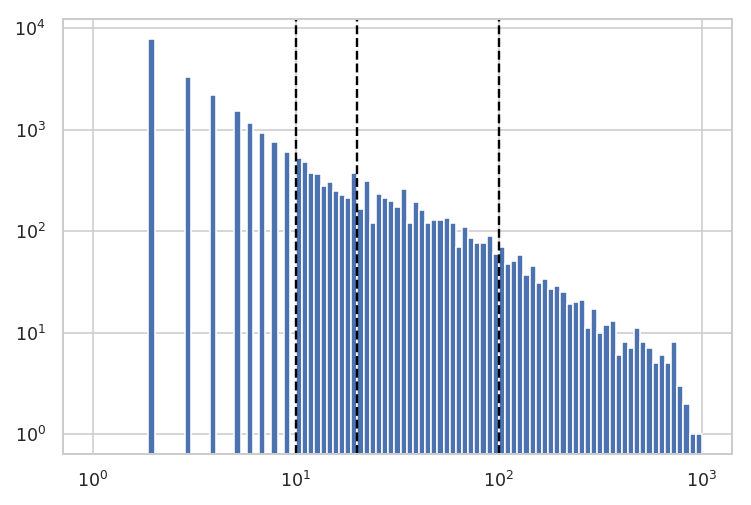

In [13]:
# circ_data = pandas.read_table(data_dir / 'circRNAgenes.txt').loc[lambda df: df.Pattern == '10']
all_circ_data = pandas.read_csv(data_dir / 'trine_line_data/circAnno_ciri2.csv')
g = plt.hist(all_circ_data.sumReads, bins=numpy.logspace(0,numpy.log10(1000), 100), log=True)
ax = plt.gca()
g = ax.set_xscale("log", nonposx='clip')
g = ax.axvline(10, color='black', linestyle='dashed')
g = ax.axvline(20, color='black', linestyle='dashed')
g = ax.axvline(100, color='black', linestyle='dashed')

In [14]:
(pandas
 .read_csv(data_dir / 'trine_line_data/circAnno_ciri2.csv')
 .loc[lambda df: (df.Pattern == '10') & (df.chr == 'chrX')]
)['gene_name']

25581     RPGR
25582     RPGR
25583     RPGR
25616    TEX11
25617    TEX11
Name: gene_name, dtype: object

In [15]:
circ_data = (all_circ_data
             .assign(chrom = lambda df: [x.replace('chr', '') for x in df.chr])
             .loc[lambda df: df.sumReads >= 20]
             .loc[lambda df: df.Pattern.isin(['9', '10', '11'])]
             .loc[lambda df: ~df.chrom.isin(['X', 'Y'])]
            )

## Chromosome ideogram code

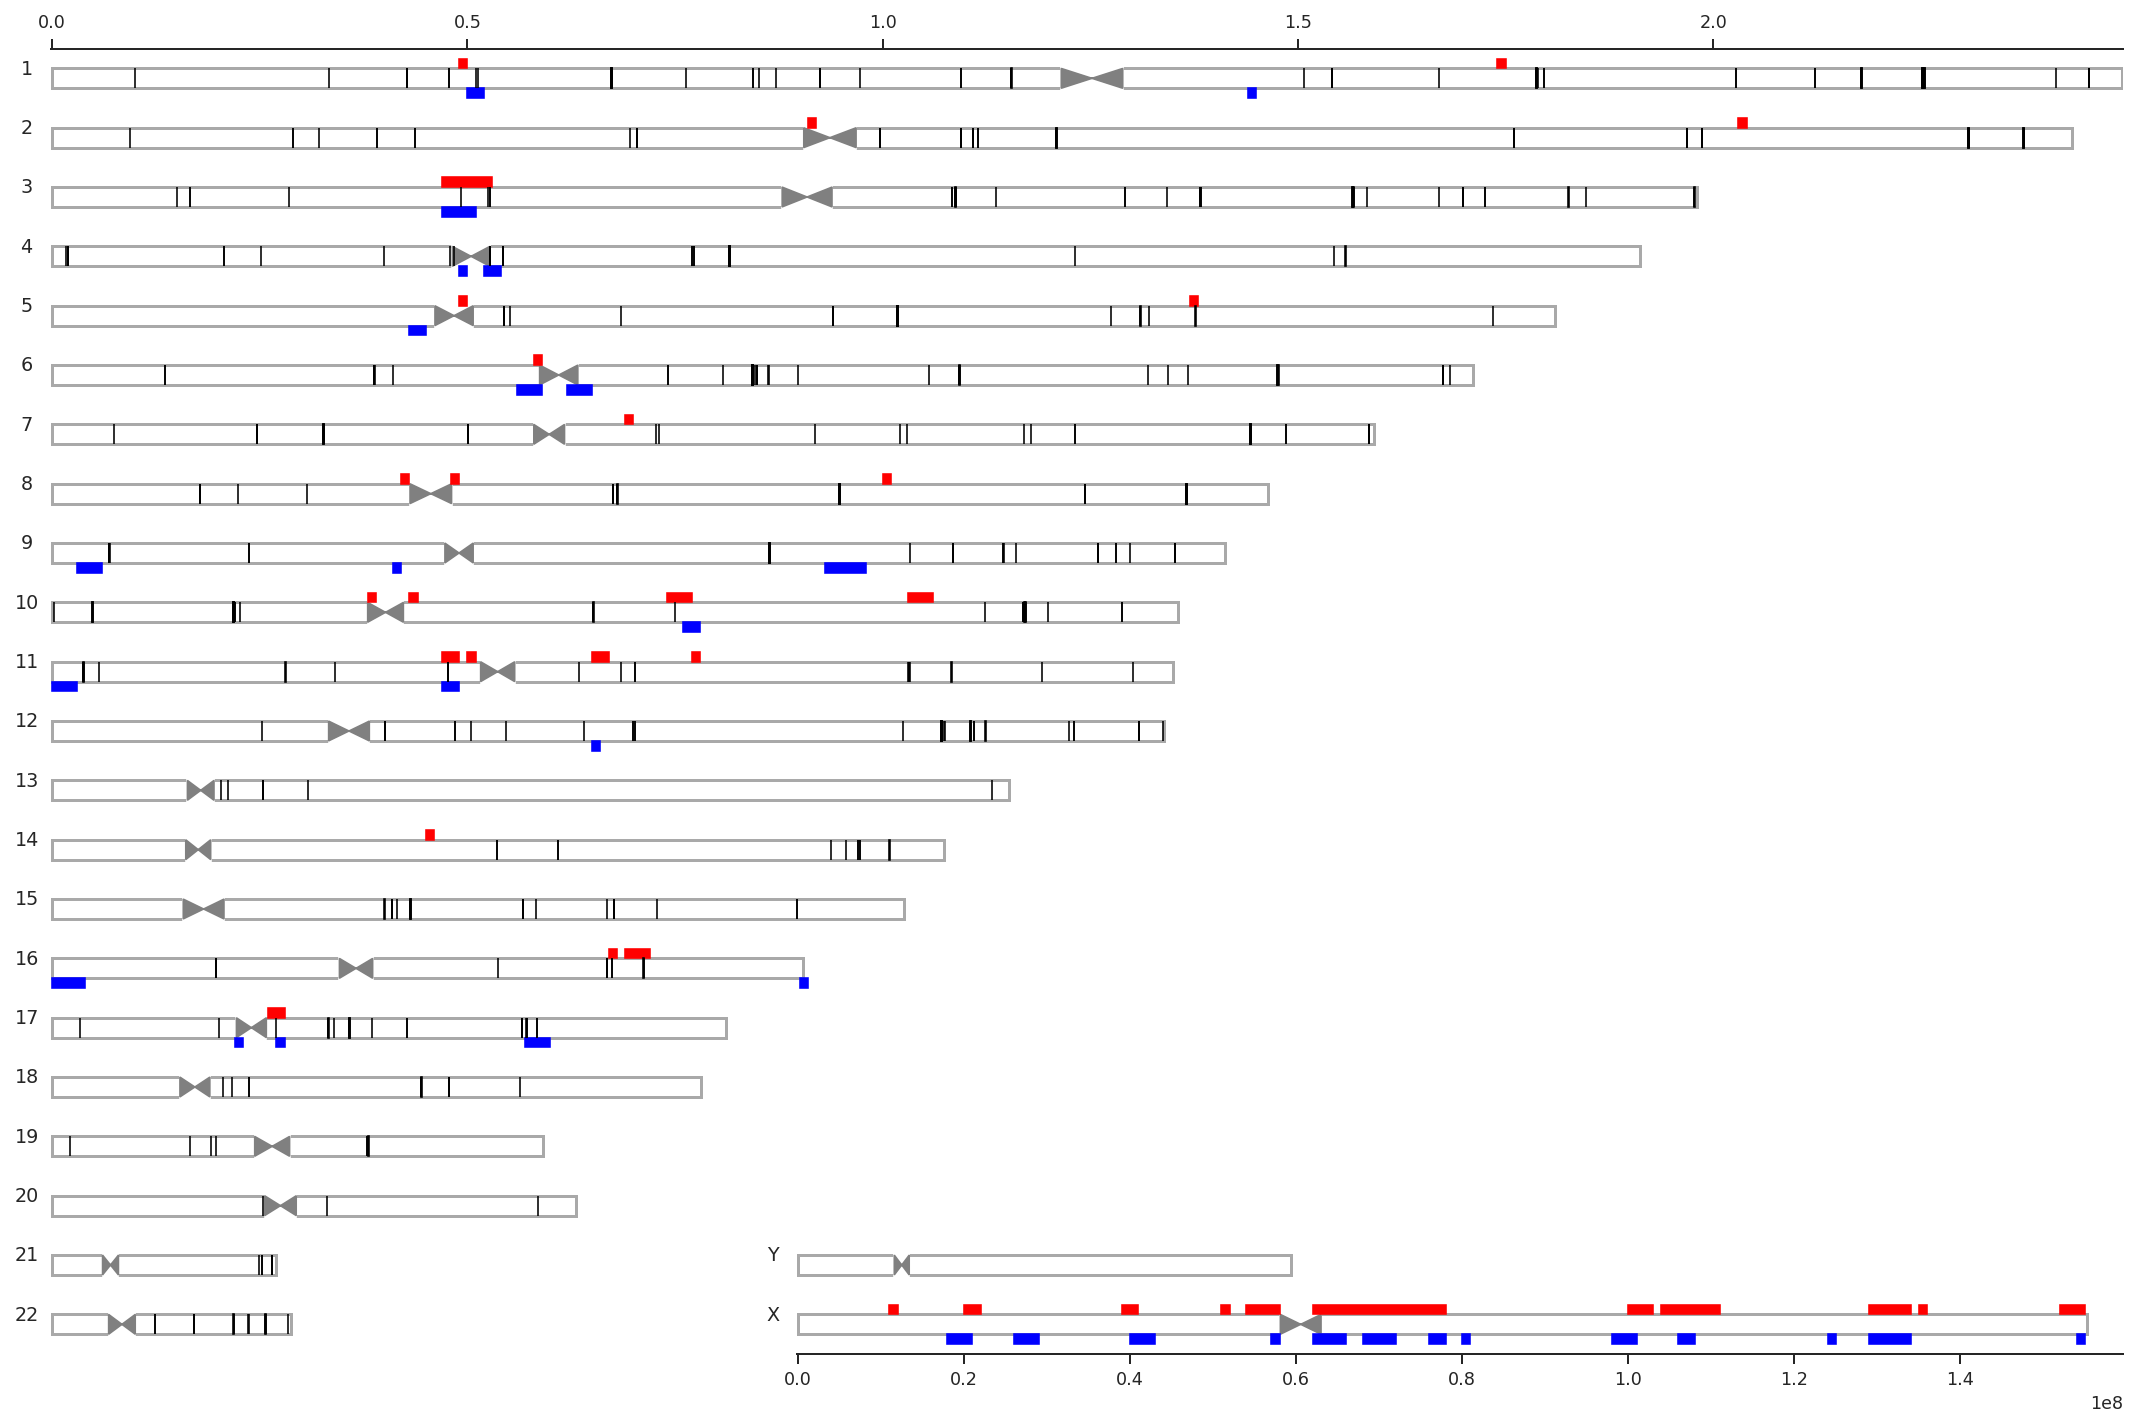

In [16]:
nr_rows, nr_cols = len(chr_names)-2, 2
with sns.color_palette("Set1"):
    with sns.axes_style('white'): # whitegrid, ticks
        with sns.plotting_context('paper', font_scale=1): # paper, notebook, talk”, poster
            fig = plt.figure(figsize = (15,10))

            
            gs = gridspec.GridSpec(nr_rows, 25)
            gs.update(wspace=0.0, hspace=0.0) # set the spacing between axes.             
            ax_list = [plt.subplot(gs[i, :]) for i in range(nr_rows-2)]
            ax_list.append(plt.subplot(gs[nr_rows-2, :9]))
            ax_list.append(plt.subplot(gs[nr_rows-1, :9]))
            ax_list.append(plt.subplot(gs[nr_rows-2, 9:]))
            ax_list.append(plt.subplot(gs[nr_rows-1, 9:]))

            chr_axes = dict(zip(chr_names, ax_list))
            
            for ax in ax_list[:-4]:
                ax.set_xlim((-100000, figwidth+100000))
            for ax in ax_list[-4:]:
                ax.set_xlim((-100000, ((25-9)/25)*figwidth+100000))

            for i in range(len(ax_list)):
                chrom = chr_names[i]
                ax = ax_list[i]
                start, end = 0, chr_lens[i] 
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.set_ylim((0, 3))
                h = ax.set_ylabel(chrom)
                h.set_rotation(0)
                ax.set_yticklabels([])

                if i == 0:
                    ax.spines['top'].set_visible(True)
                    ax.xaxis.tick_top()
                    ax.xaxis.set_label_position('top') 
                elif i == len(ax_list)-1:
                    ax.xaxis.tick_bottom()
                    ax.spines['bottom'].set_visible(True)                    
                else:
                    ax.set_xticklabels([])

                
                # draw chrom
                g = ax.add_patch(Rectangle((start, 1), end-start, 1, 
                                           fill=False,
                                           color='darkgrey',
                                           edgecolor=None,
                                           zorder=1, linewidth=1.5
                                          ))
                
                # draw centromere
                cent_start, cent_end = centromeres[chrom]
                
                ax.add_patch(Rectangle((cent_start, 0), cent_end-cent_start, 3, 
                                           fill=True, color='white',
                                           zorder=2))
                
                xy = [[cent_start, 1], [cent_start, 2], [cent_end, 1], [cent_end, 2]]
                g = ax.add_patch(Polygon(xy, closed=True, zorder=3, fill=True, color='grey'))

                
                
#             for chrom, gr in circ_data.groupby('chr'):
#                 chrom = chrom.replace('chr', '')
#                 if chrom in chr_axes:
#                     g = chr_axes[chrom.replace('chr', '')].scatter(gr.start+(gr.end-gr.start)/2, 
#                                                                    numpy.repeat(1, len(gr.start)),
#                                                                    color='red', marker='x', zorder=2)

            min_run_len = 1
            for tup in human_chimp_ils.loc[lambda df: df.run >= min_run_len].itertuples():
                g = chr_axes[tup.chrom].add_patch(Rectangle((tup.start, 2), tup.end-tup.start, 0.5, 
                                           fill=True, color='red',
                                           zorder=4))
            for tup in human_orang_ils.loc[lambda df: df.run >= min_run_len].itertuples():
                g = chr_axes[tup.chrom].add_patch(Rectangle((tup.start, 0.5), tup.end-tup.start, 0.5, 
                                           fill=True, color='blue',
                                           zorder=4))
                

            for tup in circ_data.itertuples():
                g = chr_axes[tup.chrom].add_patch(Rectangle((tup.start, 1), tup.end-tup.start, 1, 
                                           fill=True, color='black',
                                           zorder=5))
                
#                 g = chr_axes[name].plot(tup.start+(tup.end-tup.start)/2, 2, 'bo', markersize=5, zorder=2)
#                 g = chr_axes[name].scatter(tup.start+(tup.end-tup.start)/2, 1, color='red', marker='x', zorder=2)

#                 g = chr_axes[name].plot(tup.start+(tup.end-tup.start)/2, 1, 'rX', markersize=5, zorder=2)
    
plt.tight_layout()
#mpld3.display(fig)

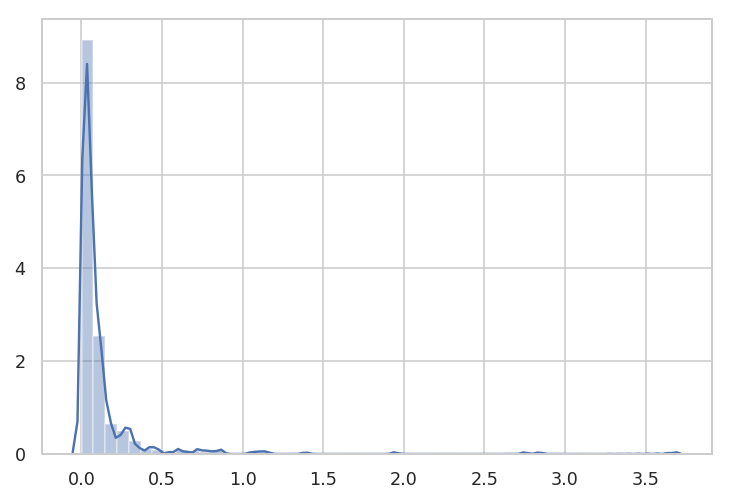

In [35]:
sns.distplot(circ_data.sumReads / circ_data.linReads)

In [37]:
circ_data.loc[(circ_data.chr == 'chr3') & (circ_data.start > 45000000) & (circ_data.end < 55000000), ['circRNA_ID', 'chr', 'start', 'end', 'strand', 'gene_id',
       'circRNA_type', 'genomic_size', 'sumReads', 'mean', 'max', 'sumExp',
       'median','gene_name', 
       'circBase_spliced_length', 'circBase_samples', 'linReads', 'Pattern']].assign(ratio=lambda df: df.sumReads/df.linReads)

,circRNA_ID,chr,start,end,strand,gene_id,circRNA_type,genomic_size,sumReads,mean,max,sumExp,median,gene_name,circBase_spliced_length,circBase_samples,linReads,Pattern,ratio
17262,chr3:49249198-49282166,chr3,49249198,49282166,+,"gencode::CCDC36::tc_ENSG00000173421.12,",exon,32968,48,4.000000,25,3,0.0,CCDC36,NaN,NaN,577,11,0.083189
17311,chr3:52446826-52448603,chr3,52446826,52448603,+,"gencode::PHF7::tc_ENSG00000010318.15,",exon,1777,88,7.333333,21,7,5.0,PHF7,255.0,"Hs68_RNase, Hs68_control, K562, Helas3, H1hesc...",61248,11,0.001437
17321,chr3:52771601-52773650,chr3,52771601,52773650,-,"gencode::NEK4::tc_ENSG00000114904.8,",exon,2049,58,4.833333,24,4,0.0,NEK4,340.0,cd_19,2297,11,0.025250
17322,chr3:52771601-52775515,chr3,52771601,52775515,-,"gencode::NEK4::tc_ENSG00000114904.8,",exon,3914,196,16.333333,57,6,8.5,NEK4,429.0,"cd_19, Hs68_RNase, Hs68_control, K562, H1hesc,...",2003,11,0.097853


In [18]:
circ_data.loc[(circ_data.chr == 'chr1') & (circ_data.start > 45000000) & (circ_data.end < 55000000)]

,Unnamed: 0,circRNA_ID,chr,start,end,strand,gene_id,circRNA_type,genomic_size,sumReads,...,SCE_exp_bp,SCE_obs_bp,SCE_fraction_overlap,miRNA_exp_nr,miRNA_obs_nr,size_exon,max_miRNA_freq,max_miRNA_family,max_miRNA_seeq_seq,chrom
1937,chr1:47745912-47748131,chr1:47745912-47748131,chr1,47745912,47748131,-,"gencode::STIL::tc_ENSG00000123473.11,",exon,2219,90,...,5.429526,0.0,0.000000,1.076607,0.0,1084.0,0,NaN,NaN,1
1941,chr1:47761436-47767420,chr1:47761436-47767420,chr1,47761436,47767420,-,"gencode::STIL::tc_ENSG00000123473.11,",exon,5984,30,...,2.604570,0.0,0.000000,0.516453,0.0,520.0,0,NaN,NaN,1
1987,chr1:51032748-51061888,chr1:51032748-51061888,chr1,51032748,51061888,-,"gencode::FAF1::tc_ENSG00000185104.15,",exon,29140,29,...,2.624605,60.0,0.114504,0.520426,1.0,524.0,1,miR-182,UUGGCAA,1
1994,chr1:51253671-51267349,chr1:51253671-51267349,chr1,51253671,51267349,-,"gencode::FAF1::tc_ENSG00000185104.15,",exon,13678,20,...,1.267223,0.0,0.000000,0.251274,2.0,253.0,1,miR-296-3p,AGGGUUG,1


In [19]:
circ_data.loc[(circ_data.chr == 'chr11') & (circ_data.start > 45000000) & (circ_data.end < 55000000)]

,Unnamed: 0,circRNA_ID,chr,start,end,strand,gene_id,circRNA_type,genomic_size,sumReads,...,SCE_exp_bp,SCE_obs_bp,SCE_fraction_overlap,miRNA_exp_nr,miRNA_obs_nr,size_exon,max_miRNA_freq,max_miRNA_family,max_miRNA_seeq_seq,chrom
4441,chr11:47648631-47657123,chr11:47648631-47657123,chr11,47648631,47657123,-,"gencode::MTCH2::tc_ENSG00000109919.5,",exon,8492,21,...,2.013533,0.0,0.000000,0.399258,1.0,402.0,1,miR-377,UCACACA,11
4442,chr11:47650504-47652639,chr11:47650504-47652639,chr11,47650504,47652639,-,"gencode::MTCH2::tc_ENSG00000109919.5,",exon,2135,25,...,1.031810,0.0,0.000000,0.204595,0.0,206.0,0,NaN,NaN,11
4446,chr11:47684577-47701625,chr11:47684577-47701625,chr11,47684577,47701625,-,"gencode::AGBL2::tc_ENSG00000165923.11,",exon,17048,24,...,3.105448,45.0,0.072581,0.615771,0.0,620.0,0,NaN,NaN,11


In [20]:
# def overlapping_intervals(genes, peaks):    
#     lst = list()
#     for tup in peaks.itertuples():
#         df = genes.copy().loc[(genes.chrom == tup.chrom) & (genes.start < tup.end) & (genes.end > tup.start)]
#         df['low_ils_start'] = tup.start
#         df['low_ils_end'] = tup.end
#         lst.append(df)
#     return pandas.concat(lst)

In [21]:
#overlapping_intervals(circ_data, human_chimp_ils)

In [22]:
import GenomicIntervals
from GenomicIntervals import bootstrap, by_chrom
# import imp
# imp.reload(GenomicIntervals)

In [23]:
autosomes = list(map(str, range(23)))

collapsed_circ_data = GenomicIntervals.interval_collapse(circ_data)
del collapsed_circ_data['index'] # Hack: GenomicIntervals should do this...

autosome_low_ils = (human_chimp_ils
                    .loc[lambda df: df.chrom.isin(autosomes)]
                   )

# NB: instead of biomart genes I should use the set of genes used in the ciri2 pipeline
autosome_genes = (pandas.read_hdf(results_dir / 'biomart_genes.hdf')
                         .loc[lambda df: df.chrom.isin(autosomes) & (df['Gene type'] == 'protein_coding')]
                         )
collapsed_autosome_genes = GenomicIntervals.interval_collapse(autosome_genes)
del collapsed_autosome_genes['index'] # Hack: GenomicIntervals should do this...

len(collapsed_circ_data), len(autosome_low_ils), len(collapsed_autosome_genes)

(297, 24, 15719)

In [24]:
@by_chrom
def genes_overlapping_intervals(ils, circ):    
    lst = list()
    for tup in circ.itertuples():
        df = ils.loc[(ils.start < tup.end) & (ils.end > tup.start)]
        lst.append(df)
    return pandas.concat(lst)

@bootstrap(chromosome_lengths, samples=1000)
def count_ils_with_circ(ils, circ):
    return len(genes_overlapping_intervals(ils, circ)) / len(ils)
    


Find low ILS regions overlapping a circRNA:

In [25]:
collapsed_circ_data.head()

,start,end,chrom
0,9991948,9994918,1
1,33290913,33295668,1
2,42730785,42789498,1
3,47745912,47748131,1
4,47761436,47767420,1


In [26]:
autosome_low_ils.head()

,chrom,test,end,start,prop_ils,run
1,17,2,28000000,26000000,0.020825,2
1,2,2,92000000,91000000,0.045534,1
3,2,4,204000000,203000000,0.032888,1
1,10,2,39000000,38000000,0.034783,1
3,10,4,44000000,43000000,0.047739,1


In [27]:
low_ils_with_circ = (genes_overlapping_intervals((autosome_low_ils
                                                  .loc[lambda df: df.chrom.isin(collapsed_circ_data.chrom.unique())]
                                                 ), 
                                                 (collapsed_circ_data
                                                  .loc[lambda df: df.chrom.isin(autosome_low_ils.chrom.unique())]
                                                 ))
                     .drop_duplicates()
                    )
low_ils_with_circ

,level_0,index,chrom,test,end,start,prop_ils,run
0,5,5,10,6,77000000,74000000,0.033318,3
1,14,1,11,2,49000000,47000000,0.025925,2
3,20,1,16,2,68000000,67000000,0.037619,1
4,21,3,16,4,72000000,69000000,0.030979,3
5,0,1,17,2,28000000,26000000,0.020825,2
6,22,1,3,2,53000000,47000000,0.014290,6
9,10,3,5,4,138000000,137000000,0.037969,1


Find circRNAs overlapping low ILS regions:

In [28]:
collapsed_circ_data.head()

,start,end,chrom
0,9991948,9994918,1
1,33290913,33295668,1
2,42730785,42789498,1
3,47745912,47748131,1
4,47761436,47767420,1


In [29]:
circ_in_low_ils = (genes_overlapping_intervals((collapsed_circ_data
                                                  .loc[lambda df: df.chrom.isin(autosome_low_ils.chrom.unique())]
                                                 ),
                                                 (autosome_low_ils
                                                  .loc[lambda df: df.chrom.isin(collapsed_circ_data.chrom.unique())]
                                                 ))
                     .drop_duplicates()
                    )
circ_in_low_ils

,level_0,index,start,end,chrom
0,44,44,75029371,75038095,10
1,57,57,47648631,47652639,11
2,58,58,47684577,47701625,11
3,79,116,67397492,67405145,16
4,80,117,71186561,71220821,16
5,83,120,26918715,26920084,17
6,118,184,49249198,49282166,3
7,119,185,52446826,52448603,3
8,120,186,52771601,52775515,3
9,148,229,137654907,137665336,5


In [30]:
genes_in_low_ils = (genes_overlapping_intervals((collapsed_autosome_genes
                                                  .loc[lambda df: df.chrom.isin(autosome_low_ils.chrom.unique())]
                                                 ),
                                                 (autosome_low_ils
                                                  .loc[lambda df: df.chrom.isin(collapsed_circ_data.chrom.unique())]
                                                 ))
                     .drop_duplicates()
                    )
genes_in_low_ils.head()

,level_0,index,start,end,chrom
0,573,573,48998527,49242641,1
1,1331,1331,174128548,174418683,1
2,1332,1332,174968300,174992561,1
3,1909,1909,38091751,38147034,10
4,1910,1910,38238500,38265561,10


Enrichment of circRNA in low ILS regions:

In [31]:
count_ils_with_circ(ils.loc[lambda df: df.chrom.isin(collapsed.chrom.unique())], 
                    collapsed.loc[lambda df: df.chrom.isin(human_chimp_ils.chrom.unique())] )

NameError: name 'ils' is not defined

circRNA to gene count in low ILS and in all autosomes:

In [ ]:
len(circ_in_low_ils) / len(genes_in_low_ils), len(collapsed_circ_data) / len(collapsed_autosome_genes)

In [ ]:
len(circ_in_low_ils), len(genes_in_low_ils), len(collapsed_circ_data), len(collapsed_autosome_genes)

In [ ]:
len(collapsed_circ_data.loc[lambda df: df.chrom.isin(autosome_low_ils.chrom.unique())])

In [ ]:
len(collapsed_autosome_genes.loc[lambda df: df.chrom.isin(autosome_low_ils.chrom.unique())])

In [ ]:
import scipy

scipy.stats.binom_test(len(circ_in_low_ils), 
                       len(genes_in_low_ils),
                       len(collapsed_circ_data) / len(collapsed_autosome_genes),
                       alternative='greater')

